# Andrea - 2201916943

# Import
Pada bagian ini terdapat bagian untuk melakukan import library yang akan digunakan dalam projek ini.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive 
from tensorflow.keras.layers import TimeDistributed, Conv1D, LSTM, Dense, Flatten, MaxPooling1D, Dropout

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Load Dataset
Dataset yang digunakan merupakan dataset Timeseries saham. Harga saham yang akan digunakan adalah harga saham BBRI. Dataset diperoleh dari https://finance.yahoo.com/quote/BBRI.JK/history?p=BBRI.JK. Dataset tersebut lalu diunduh dan disimpan dalam Google Drive pribadi.

In [3]:
drive.mount('/content/gdrive', force_remount=True)
df = pd.read_csv('gdrive/My Drive/Public/BBRI.JK.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Filter Dataset
Filter pada data ini digunakan untuk mengambil data Close pada BBRI saja.

In [4]:
data = df.filter(['Close'])
dataset = data.values

# Feature Scaling
Data yang telah difilter lalu dilalukan Feature Scaling menggunakan Min-Max Normalization.

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Splitting Data
Data lalu akan dipersiapkan x_train dan y_train untuk dilakukan training

In [6]:
training_data_len = math.ceil(len(dataset) * .8)
train_data = scaled_data[0:training_data_len,:]

x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train) , np.array(y_train)
x_train = x_train.reshape((x_train.shape[0], 30, 2, 1))

# Create Model
Model akan dibuatkan arsitektur untuk dilakukan pelatihan. Model akan terdiri dari beberapa layer seperti berikut.

In [8]:
model = tf.keras.Sequential()

model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(None, 2, 1))))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.25)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, batch_size = 1, epochs=1)

145/145 [==============================] - 1s 7ms/step - loss: 0.0196


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (1, 30, 2, 32)            64        
_________________________________________________________________
time_distributed_5 (TimeDist (1, 30, 1, 32)            0         
_________________________________________________________________
time_distributed_6 (TimeDist (1, 30, 1, 32)            0         
_________________________________________________________________
time_distributed_7 (TimeDist (1, 30, 32)               0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 64)                   24832     
_________________________________________________________________
dense_5 (Dense)              (1, 64)                   4160      
_________________________________________________________________
dense_6 (Dense)              (1, 32)                  

# Final Result
Setelah model telah dilakukan training, model akan digunakan untuk prediksi data. Dari prediksi, kita juga dapat menghitung nilai RMSE sebagai nilai error.

In [10]:
test_data = scaled_data[training_data_len - 60:, :]
x_test =[]
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)) :
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0], 30, 2, 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

223.24708467371323

# Visualizing
Bagian ini merupakan visualisasi dari data dan model yang telah dibuat. Visualisasi akan sangat berguna dalam memahami hasil dari model.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


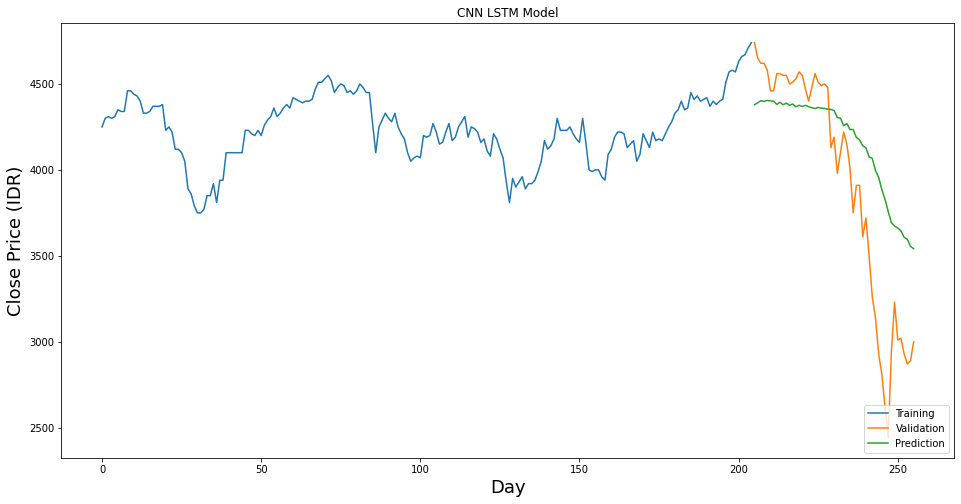

In [16]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.show()

plt.figure(figsize=(16,8))
plt.title("CNN LSTM Model")
plt.xlabel('Day', fontsize = 18)
plt.ylabel('Close Price (IDR)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Prediction'], loc='lower right')

In [17]:

plt.show()
